# 2nd Level Model Structure: Reactive Stage

In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))
import numpy as np
from matplotlib import pyplot as plt

In [2]:
from pyomo import environ as pe
from global_sets.component import m
from utility.display_utility import trans_product_mole, trans_product_mass
from utility.model_utility import add_dual, update_dual, check_DOF

# stage construction rules
from physics.kinetics_bounded import kinetic_block_rule
from physics.energy_bounded import energy_block_rule
from physics.VLE_bounded import VLE_block_rule

model = pe.ConcreteModel()

# Global Sets (Inlet / Outlet)

In [3]:
model.inlet = pe.Set(initialize=['in'])
model.outlet = pe.Set(initialize=['out','P'])
model.stream = model.inlet | model.outlet

# Global Variables

In [4]:
# Tray Inlet/Outlet Variable
model.x_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y_ = pe.Var(model.inlet,m.COMP_TOTAL,within=pe.NonNegativeReals)
model.x = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.y = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals)
model.z = pe.Var(m.COMP_FEED,within=pe.NonNegativeReals)

model.L = pe.Var(model.stream,within=pe.NonNegativeReals)
model.V = pe.Var(model.stream,within=pe.NonNegativeReals)
model.F = pe.Var(within=pe.NonNegativeReals)

model.H_L_ = pe.Var(model.inlet,within=pe.Reals)
model.H_V_ = pe.Var(model.inlet,within=pe.Reals)
model.H_L = pe.Var(within=pe.Reals)
model.H_V = pe.Var(within=pe.Reals)
model.H_F = pe.Var(within=pe.Reals)

# State Variable
model.T = pe.Var(within=pe.NonNegativeReals,bounds=(200+273.15,300+273.15)) # K
model.T_F = pe.Var(within=pe.NonNegativeReals) # K
model.P = pe.Var(within=pe.NonNegativeReals,bounds=(10,30)) # Bar

model.f_V = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)
model.f_L = pe.Var(m.COMP_TOTAL,within=pe.NonNegativeReals,initialize=1e-20)

model.cat = pe.Var(within=pe.NonNegativeReals) # kg
model.Q_main = pe.Var(within=pe.Reals) # MW
model.r_total_comp = pe.Var(m.COMP_TOTAL,within=pe.Reals) # kmol/s

# Construct Individual Blocks

In [5]:
model.kinetics_block = pe.Block(rule=kinetic_block_rule)

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| kinetics_block.k_FT
| kinetics_block.r_FT_total
| kinetics_block.g0_FT
| kinetics_block.alpha
| kinetics_block.r_FT_cnum
| kinetics_block.r_FT_comp
| kinetics_block.k_WGS
| kinetics_block.Ke_WGS
| kinetics_block.r_WGS
| kinetics_block.r_WGS_comp
--------------------------------------------------



In [6]:
model.energy_block = pe.Block(rule=energy_block_rule)

> Importing Energy Blocks......
> Adding the following local variable:
--------------------------------------------------
| energy_block.dH_F
| energy_block.dH_V
| energy_block.dH_L
| energy_block.dH_vap
--------------------------------------------------



In [7]:
model.VLE_block = pe.Block(rule=VLE_block_rule)

> Importing VLE Blocks......
> Adding the following local variable:
--------------------------------------------------
| VLE_block.n_ave
| VLE_block.n_ave_cal
| VLE_block.Hen
| VLE_block.Hen0
| VLE_block.gamma
| VLE_block.P_sat
| VLE_block.P_sat_Y
| VLE_block.P_sat_dY_inf
| VLE_block.P_sat_dY0
| VLE_block.Hen_ref
| VLE_block.Hen0_ref
| VLE_block.gamma_ref
| VLE_block.V_L
| VLE_block.V_L_dY_inf
| VLE_block.V_L_dY0
| VLE_block.poynting
--------------------------------------------------



# Standard MESH Equations

## Mass Balance

\begin{equation}
Fz_{i}+\sum_{s\in{inlet}}L_{s}x'_{i,s}+\sum_{s\in{inlet}}V_{s}y'_{i,s}-\sum_{s\in{outlet}}L_{s}x_{i,s}+\sum_{s\in{ouelet}}V_{s}y_{i,s}+R_{i} = 0 \\
i = 1,...NC
\end{equation}

In [8]:
def mass_balance_main_rule(model,i):
    if i in m.COMP_FEED:
        return model.F*model.z[i] + sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
    else:
        return sum(model.L[s]*model.x_[s,i] + model.V[s]*model.y_[s,i] for s in model.inlet)\
        + model.r_total_comp[i] - sum(model.L[s]*model.x[i] + model.V[s]*model.y[i] for s in model.outlet) == 0
model.mass_balance_main_con = pe.Constraint(m.COMP_TOTAL,rule=mass_balance_main_rule)

## Equilibrium

\begin{align}
&f_{i,V} = f_{i,L} \\
&i = 1,...NC
\end{align}

In [9]:
def VL_equil_rule(model,i):
    return model.f_V[i] == model.f_L[i]
model.VL_equil_con = pe.Constraint(m.COMP_TOTAL,rule=VL_equil_rule)

## Summation

\begin{equation}
\sum_ix_{i} = \sum_iy_{i} \\
F + L_{in} + V_{in} + R = L_{out} + V_{out}
\end{equation}

In [10]:
def summation_x_y_rule(model):
    return sum(model.x[i] for i in m.COMP_TOTAL) == sum(model.y[i] for i in m.COMP_TOTAL)
model.summation_x_y_con = pe.Constraint(rule=summation_x_y_rule)

def summation_total_mass_rule(model):
    return model.F + sum(model.L[s] + model.V[s] for s in model.inlet) + sum(model.r_total_comp[i] for i in m.COMP_TOTAL)\
            - sum(model.L[s] + model.V[s] for s in model.outlet) == 0
model.summation_total_mass_con = pe.Constraint(rule=summation_total_mass_rule)

## Energy Balance

\begin{equation}
F H_f+\sum_{s\in{inlet}}L_{s}H_{l,s}+\sum_{s\in{inlet}}V_{s}H_{v,s}-\sum_{s\in{outlet}}L_{s}H_{l,s}-\sum_{s\in{outlet}}V_{s}H_{v,s}+Q = 0
\end{equation}

In [11]:
def heat_balance_main_rule(model):
    return model.F*model.H_F + sum(model.L[s]*model.H_L_[s] + model.V[s]*model.H_V_[s] for s in model.inlet) \
            + model.Q_main - sum(model.L[s]*model.H_L + model.V[s]*model.H_V for s in model.outlet) == 0
model.heat_balance_main_con = pe.Constraint(rule=heat_balance_main_rule)

# Testing

In [12]:
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


In [13]:
with open('../saved_solutions/reactive_flash_MPCC_P_pf_200C.pickle', 'rb') as f:
    C200 = pickle.load(f)

In [14]:
# model.x_.fix(0)
for i in m.COMP_TOTAL:
    model.y_['in',i].fix(C200.Solution.Variable['y[{}]'.format(i)]['Value'])
# model.L['in'].fix(0)
# model.L['out'].fix(0)
# model.V['in'].fix(1)
# model.V['P'].fix(0)
# model.H_L_.fix(0)
model.H_V_.fix(C200.Solution.Variable['H_V']['Value'])

In [15]:
with open('../saved_solutions/reactive_flash_MPCC_P_pf_200C.pickle', 'rb') as f:
    C200 = pickle.load(f)

In [16]:
# model.y_.fix(0)
for i in m.COMP_TOTAL:
    model.x_['in',i].fix(C200.Solution.Variable['x[{}]'.format(i)]['Value'])

# model.L['in'].fix(1)
# model.L['in'].setlb(1e-6)
# model.L['in'].setub(1e-8)

# model.L['P'].fix(0)
# model.V['in'].fix(0)
# model.V['P'].fix(0)
# model.H_V_.fix(0)
model.H_L_.fix(C200.Solution.Variable['H_L']['Value'])

## Fixing In/Product Redundent Flow

In [17]:
# model.x_.fix(0)
# model.y_.fix(0)
model.L['in'].fix(1)
model.L['P'].fix(0)
model.V['in'].fix(1)
model.V['P'].fix(0)
# model.H_L_.fix(0)
# model.H_V_.fix(0)

## Fixing Model Parameters

In [18]:
model.cat.fix(0)
model.P.fix(20)
model.T_F.fix(200+273.15)
model.F.fix(0.5)
model.z['CO'].fix(1/(1+0.8)-0.01/2)
model.z['H2'].fix(0.8/(1+0.8)-0.01/2)
model.z['C30H62'].fix(0.01)
model.VLE_block.n_ave.fix(20)
model.Q_main.fix(0)

In [19]:
check_DOF(pe,model)

Active Equality Constraints:	 1181
Active Inequality Constraints:	 0
Active Variables:		 1354
Fixed Variables:		 173
DOF:				 0


## Fix T or to fix Q? we have found that Maximize against an upper bound is most reliable

In [20]:
model.T.setub(300+273.15)

In [21]:
# model.obj = pe.Objective(expr = model.L['out'],sense=pe.maximize)
# model.obj = pe.Objective(expr = model.Q_main,sense=pe.maximize)
model.obj = pe.Objective(expr = 1,sense=pe.maximize)

In [22]:
opt = pe.SolverFactory('ipopt')

opt.options['print_user_options'] = 'yes'
# opt.options['linear_solver'] = 'ma86'
# opt.options['nlp_scaling_method'] = None
# opt.options['bound_relax_factor'] = 0
# opt.options['halt_on_ampl_error'] = 'yes'

opt.options['max_iter'] = 7000
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.11.1: print_user_options=yes
max_iter=7000


List of user-set options:

                                    Name   Value                used
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:     3925
Number of nonzeros in inequality constraint Jacob

  89r-1.0000000e+000 1.46e+000 6.45e+003  -2.5 4.16e+002    -  8.60e-001 1.69e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90r-1.0000000e+000 3.04e+000 6.68e+002  -2.5 4.85e+002    -  2.25e-001 8.31e-001f  1
  91r-1.0000000e+000 1.84e-001 3.04e+001  -2.5 1.53e+001    -  1.00e+000 9.72e-001f  1
  92r-1.0000000e+000 1.25e-001 9.45e-004  -2.5 1.60e+000    -  1.00e+000 1.00e+000h  1
  93r-1.0000000e+000 1.25e-001 3.18e+002  -5.7 2.78e+001    -  4.97e-001 6.82e-001f  1
  94r-1.0000000e+000 2.43e-001 3.04e+003  -5.7 7.67e+001  -1.0 4.08e-002 1.77e-001f  1
  95r-1.0000000e+000 2.72e-001 6.09e+002  -5.7 5.17e+002  -1.5 2.16e-002 6.75e-003f  1
  96r-1.0000000e+000 2.82e-001 3.94e+003  -5.7 9.37e+001  -1.1 2.02e-001 3.91e-002f  1
  97r-1.0000000e+000 2.85e-001 8.13e+003  -5.7 7.07e+002  -1.5 2.16e-002 1.83e-003f  1
  98r-1.0000000e+000 2.86e-001 8.97e+003  -5.7 1.03e+002  -1.1 8.15e-002 2.05e-002f  1
  99r-1.0000000e+000 2.88e-001 8.60e+003  -5.7 2.

 175r-1.0000000e+000 6.31e+001 3.84e+003  -5.7 5.36e+003    -  1.49e-003 1.55e-004h  1
 176r-1.0000000e+000 6.30e+001 3.84e+003  -5.7 5.20e+003    -  5.92e-004 3.85e-004f  1
 177r-1.0000000e+000 6.30e+001 4.14e+003  -5.7 3.04e+003    -  1.02e-002 5.20e-004f  1
 178r-1.0000000e+000 6.28e+001 5.94e+003  -5.7 5.48e+002    -  6.24e-002 2.42e-003f  1
 179r-1.0000000e+000 6.26e+001 5.79e+003  -5.7 9.71e+003    -  2.66e-005 4.47e-003f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180r-1.0000000e+000 6.26e+001 6.23e+003  -5.7 7.85e+003    -  1.50e-002 4.07e-006h  1
 181r-1.0000000e+000 6.20e+001 6.52e+003  -5.7 5.86e+003    -  2.40e-002 1.12e-002f  1
 182r-1.0000000e+000 6.17e+001 6.15e+003  -5.7 1.20e+004    -  2.98e-005 1.06e-002f  1
 183r-1.0000000e+000 6.17e+001 6.63e+003  -5.7 1.38e+004    -  1.67e-002 1.47e-005h  1
 184r-1.0000000e+000 6.15e+001 6.42e+003  -5.7 1.71e+004    -  8.02e-004 6.81e-003f  1
 185r-1.0000000e+000 6.15e+001 6.55e+003  -5.7 1.

In [23]:
model.Q_main.value

0

In [24]:
model.T.value

473.2753385834605

In [25]:
# model.solutions.store_to(results)
# with open('../saved_solutions/reactive_flash_300C_n58.pickle','wb') as f:
#     pickle.dump(results,f)

In [26]:
print('Component\t\tLiquid: {:.4f}\t\t\tVapor: {:.4f}\t\t\tlog K'.format(model.L['out'].value,model.V['out'].value))
print('-'*108)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:8.4%}\t\t\t{:8.4%}\t\t\t{:.4f}'.format(model.x[i].value,model.y[i].value,np.log10(model.y[i].value/model.x[i].value)))

Component		Liquid: 0.9827			Vapor: 1.5173			log K
------------------------------------------------------------------------------------------------------------
H2         		 1.0847%			31.0320%			1.4565
CO         		 1.7201%			36.8243%			1.3306
CO2        		 2.5480%			21.8043%			0.9323
H2O        		 2.5763%			 8.8803%			0.5374
C2H4       		 0.0120%			 0.0810%			0.8304
C3H6       		 0.0321%			 0.0976%			0.4832
C4H8       		 0.0332%			 0.0879%			0.4225
C5H10      		 0.0562%			 0.0725%			0.1110
C6H12      		 0.1051%			 0.0721%			-0.1635
C7H14      		 0.1836%			 0.0707%			-0.4144
C8H16      		 0.3019%			 0.0677%			-0.6491
C9H18      		 0.4703%			 0.0631%			-0.8720
C10H20     		 0.6957%			 0.0571%			-1.0859
C11H22     		 0.6231%			 0.0318%			-1.2927
C12H24     		 0.8307%			 0.0266%			-1.4939
C13H26     		 1.0479%			 0.0214%			-1.6905
C14H28     		 1.2504%			 0.0164%			-1.8832
C15H30     		 1.4150%			 0.0120%			-2.0727
C16H32     		 1.5281%			 0.0084%			-2.2594
C17H34     		 1.5877%			 0.0057%

# Iterative Solve for Data Analysis

In [27]:
update_dual(pe,model)

In [28]:
opt.options['warm_start_init_point'] = 'yes'
opt.options['warm_start_bound_push'] = 1e-20
opt.options['warm_start_mult_bound_push'] = 1e-20
opt.options['mu_init'] = 1e-6

In [29]:
rf_data = {}
rf_data['r'] = {}; rf_data['T'] = []; rf_data['Q'] = []; rf_data['V'] = []; rf_data['L'] = []; 
rf_data['y_CO'] = []; rf_data['y_H2'] = []; rf_data['y_CO2'] = []; rf_data['y_H2O'] = []; rf_data['r_WGS'] = []; rf_data['r_FT'] = []
rf_data['f_V_CO'] = []; rf_data['f_V_H2'] = [];

for i in model.r_total_comp:
    rf_data['r'][i] = []
    
Trange = np.arange(300+273.15,199+273.15,-2)

for Tub in Trange:
    model.T.setub(Tub)
    results = opt.solve(model,tee=False)
    update_dual(pe,model)
    # print('-'*72)
    print('Solved, Solution T = {:.2f} K\t|\tV = {:.5f}\t|\tL = {:.5f}\t|'.format(model.T.value,model.V['out'].value,model.L['out'].value))
    # print('-'*72)
    rf_data['T'].append(model.T.value)
    rf_data['Q'].append(model.Q_main.value)
    rf_data['V'].append(model.V['out'].value)
    rf_data['L'].append(model.L['out'].value)    

    for i in model.r_total_comp:
        rf_data['r'][i].append(model.r_total_comp[i].value)
    
    
    rf_data['y_H2O'].append(model.y['H2O'].value)
    rf_data['y_CO'].append(model.y['CO'].value)
    rf_data['y_H2'].append(model.y['H2'].value)
    rf_data['y_CO2'].append(model.y['CO2'].value)
    rf_data['r_WGS'].append(model.kinetics_block.r_WGS.value)
    rf_data['r_FT'].append(model.kinetics_block.r_FT_total.value)
    
    rf_data['f_V_CO'].append(model.f_V['CO'].value)
    rf_data['f_V_H2'].append(model.f_V['H2'].value)

Solved, Solution T = 473.28 K	|	V = 1.51725	|	L = 0.98275	|
Solved, Solution T = 473.28 K	|	V = 1.51725	|	L = 0.98275	|
Solved, Solution T = 473.28 K	|	V = 1.51725	|	L = 0.98275	|
Solved, Solution T = 473.28 K	|	V = 1.51725	|	L = 0.98275	|
Solved, Solution T = 473.28 K	|	V = 1.51725	|	L = 0.98275	|
Solved, Solution T = 473.28 K	|	V = 1.51725	|	L = 0.98275	|
Solved, Solution T = 473.28 K	|	V = 1.51725	|	L = 0.98275	|
Solved, Solution T = 473.28 K	|	V = 1.51725	|	L = 0.98275	|
Solved, Solution T = 473.28 K	|	V = 1.51725	|	L = 0.98275	|
Solved, Solution T = 473.28 K	|	V = 1.51725	|	L = 0.98275	|
Solved, Solution T = 473.28 K	|	V = 1.51725	|	L = 0.98275	|
Solved, Solution T = 473.28 K	|	V = 1.51725	|	L = 0.98275	|
Solved, Solution T = 473.28 K	|	V = 1.51725	|	L = 0.98275	|
Solved, Solution T = 473.28 K	|	V = 1.51725	|	L = 0.98275	|
Solved, Solution T = 473.28 K	|	V = 1.51725	|	L = 0.98275	|
Solved, Solution T = 473.28 K	|	V = 1.51725	|	L = 0.98275	|
Solved, Solution T = 473.28 K	|	V = 1.51

## Some Observations

* This system has multiple solution under same Q.
* The reaction rate peaks at ~530K, due to decreasing $\alpha$, increasing light component, uses up more feed.
* Note that when 'fully' utilizing catalyst, the system seems to always require cooling.

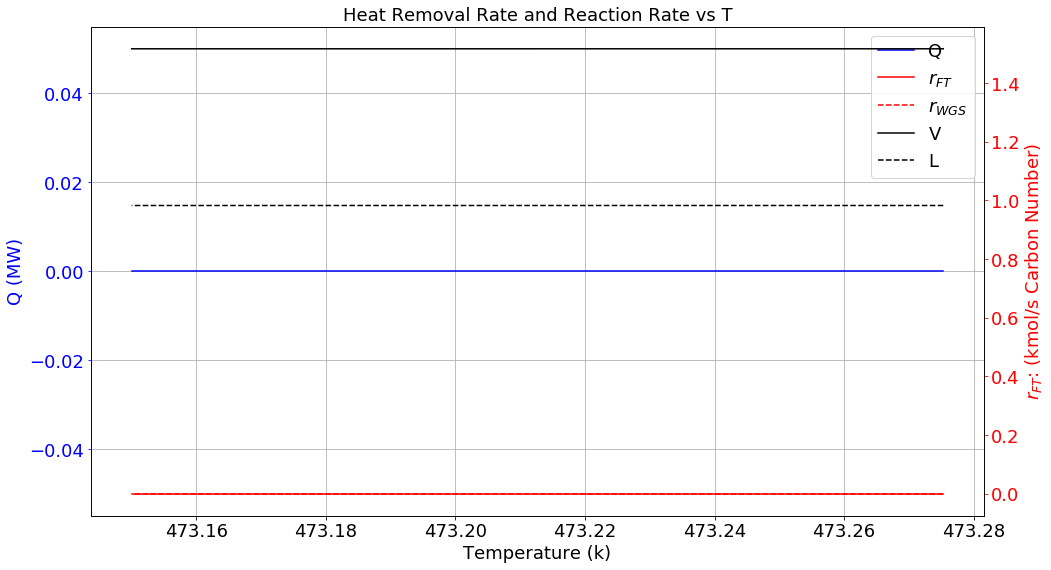

In [30]:
fig, ax1 = plt.subplots(figsize=(16,9))
line1 = ax1.plot(rf_data['T'],rf_data['Q'], 'b-')
ax1.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax1.set_ylabel('Q (MW)', color='b',fontsize=18)
ax1.tick_params('y', colors='b',labelsize=18)
ax1.tick_params('x', colors='k',labelsize=18)
ax1.grid()

ax2 = ax1.twinx()
line2 = ax2.plot(rf_data['T'],rf_data['r_FT'], 'r')
line3 = ax2.plot(rf_data['T'],rf_data['r_WGS'], 'r--')
line4 = ax2.plot(rf_data['T'],rf_data['V'], 'k')
line5 = ax2.plot(rf_data['T'],rf_data['L'], 'k--')
ax2.set_ylabel('$r_{FT}$: (kmol/s Carbon Number)', color='r',fontsize=18)
ax2.tick_params('y', colors='r',labelsize=18)

ax1.legend(line1+line2+line3+line4+line5,['Q','$r_{FT}$','$r_{WGS}$','V','L'],fontsize=18,loc=1)
ax1.set_title('Heat Removal Rate and Reaction Rate vs T',fontsize=18)
plt.show()

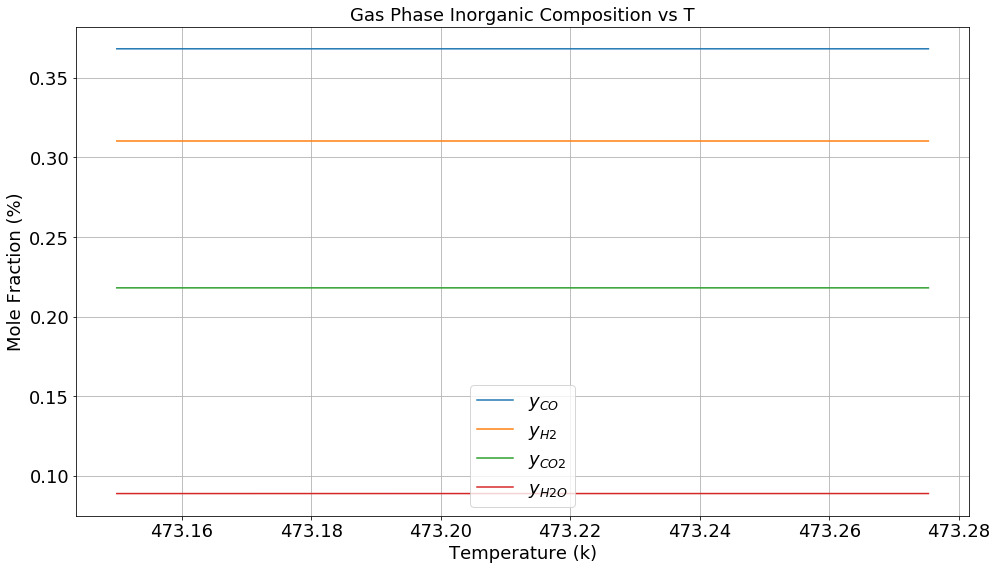

In [31]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['y_CO'])
ax.plot(rf_data['T'],rf_data['y_H2'])
ax.plot(rf_data['T'],rf_data['y_CO2'])
ax.plot(rf_data['T'],rf_data['y_H2O'])

ax.legend(['$y_{CO}$','$y_{H2}$','$y_{CO2}$','$y_{H2O}$'],fontsize=18)
ax.set_title('Gas Phase Inorganic Composition vs T',fontsize=18)

ax.set_ylabel('Mole Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()
plt.show()

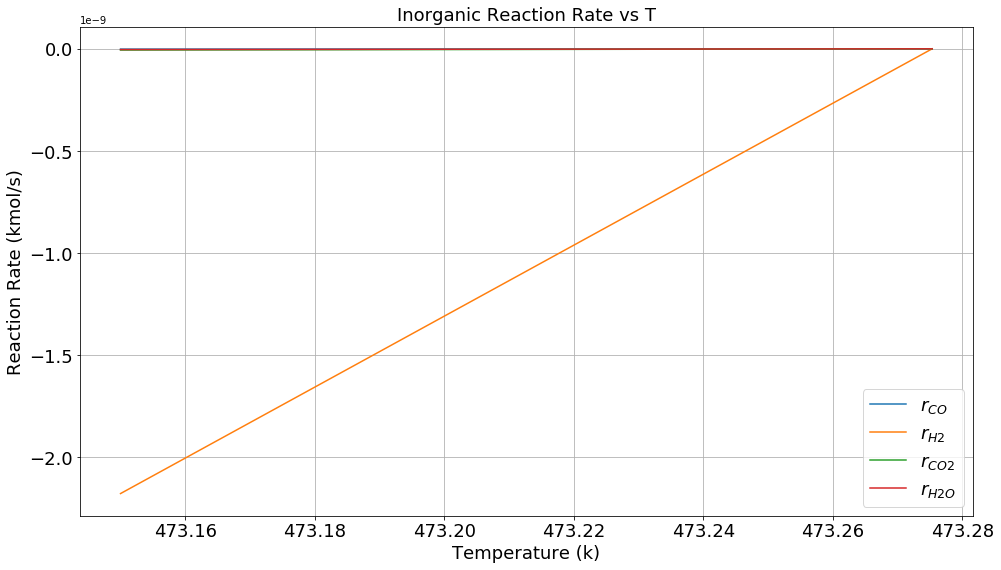

In [32]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['r']['CO'])
ax.plot(rf_data['T'],rf_data['r']['H2'])
ax.plot(rf_data['T'],rf_data['r']['CO2'])
ax.plot(rf_data['T'],rf_data['r']['H2O'])

ax.legend(['$r_{CO}$','$r_{H2}$','$r_{CO2}$','$r_{H2O}$'],fontsize=18)
ax.set_title('Inorganic Reaction Rate vs T',fontsize=18)

ax.set_ylabel('Reaction Rate (kmol/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()
plt.show()

## Product Distribution (mole)

In [33]:
reaction_data = trans_product_mole(rf_data['r'])['unscaled']
reaction_data_scaled = trans_product_mole(rf_data['r'])['scaled']

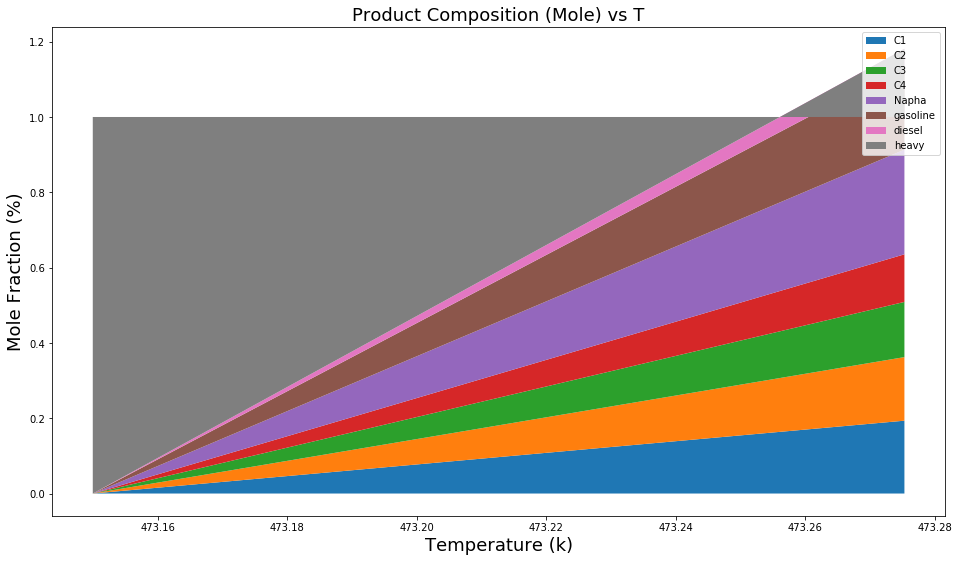

In [34]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], reaction_data_scaled['c1'], reaction_data_scaled['c2'],reaction_data_scaled['c3'],reaction_data_scaled['c4'],\
            reaction_data_scaled['napha'],reaction_data_scaled['gasoline'],reaction_data_scaled['diesel'],reaction_data_scaled['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Product Composition (Mole) vs T',fontsize=18)
ax.set_ylabel('Mole Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

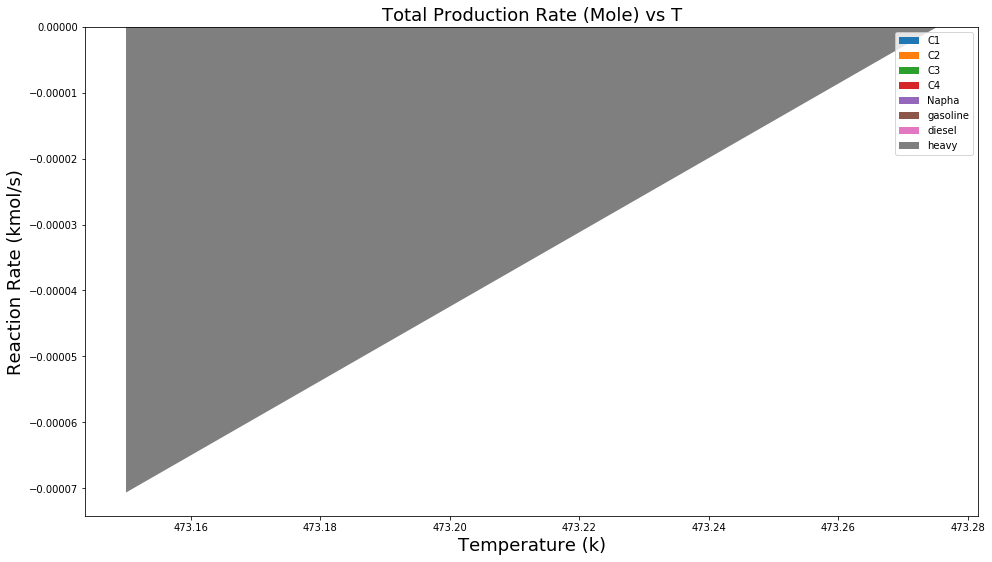

In [35]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], reaction_data['c1'], reaction_data['c2'],reaction_data['c3'],reaction_data['c4'],\
            reaction_data['napha'],reaction_data['gasoline'],reaction_data['diesel'],reaction_data['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Total Production Rate (Mole) vs T',fontsize=18)
ax.set_ylabel('Reaction Rate (kmol/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

## Product Distribution (mass)

In [36]:
mass_reaction_data = trans_product_mass(rf_data['r'])['unscaled']
mass_reaction_scaled = trans_product_mass(rf_data['r'])['scaled']

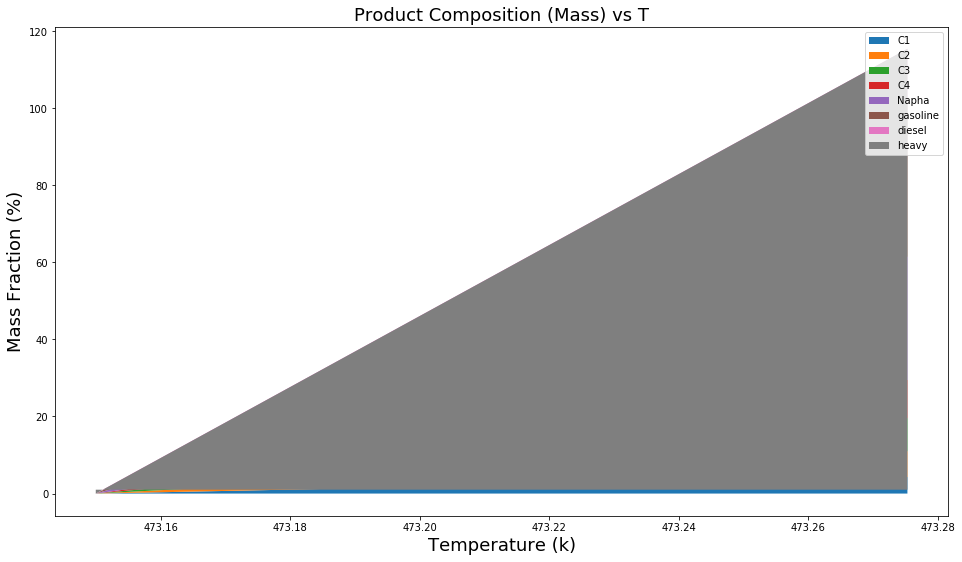

In [37]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], mass_reaction_scaled['c1'], mass_reaction_scaled['c2'],mass_reaction_scaled['c3'],mass_reaction_scaled['c4'],\
            mass_reaction_scaled['napha'],mass_reaction_scaled['gasoline'],mass_reaction_scaled['diesel'],mass_reaction_scaled['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Product Composition (Mass) vs T',fontsize=18)
ax.set_ylabel('Mass Fraction (%)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

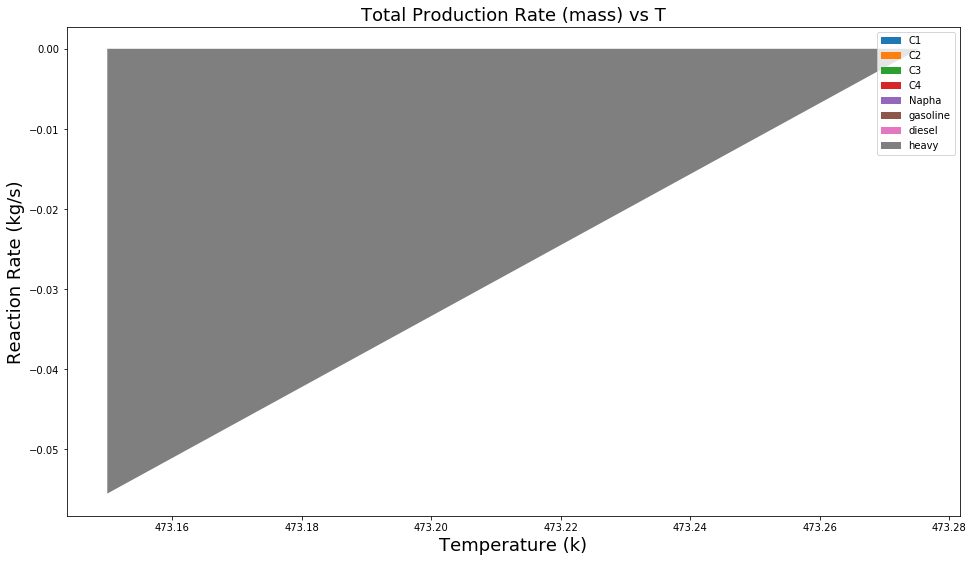

In [38]:
fig, ax = plt.subplots(figsize=(16,9))
ax.stackplot(rf_data['T'], mass_reaction_data['c1'], mass_reaction_data['c2'],mass_reaction_data['c3'],mass_reaction_data['c4'],\
            mass_reaction_data['napha'],mass_reaction_data['gasoline'],mass_reaction_data['diesel'],mass_reaction_data['heavy'])
plt.legend(['C1','C2','C3','C4','Napha','gasoline','diesel','heavy'])
ax.set_title('Total Production Rate (mass) vs T',fontsize=18)
ax.set_ylabel('Reaction Rate (kg/s)', color='K',fontsize=18)
ax.set_xlabel('Temperature (k)', color='K',fontsize=18)
plt.show()

In [39]:
# model.solutions.store_to(results)
# with open('../saved_solutions/reactive_flash_200C_n58.pickle','wb') as f:
#     pickle.dump(results,f)

# VLE Validation using AspenPlus

### Feed (Reactor Effluent)

In [40]:
print('Temperature (C): \t{:.2f}\t\t'.format(model.T.value-273.15))
print('Conversion(H2+CO): \t{:.2f}\t\t'.format(1-((model.y['CO'].value+model.y['H2'].value)*model.V['out'].value)))
print('Total FLow (kmol/s): \t{:.2f}\t\t'.format(model.L['out'].value+model.V['out'].value))
print('-'*72)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:.4%}'.format((model.x[i].value*model.L['out'].value\
        +model.y[i].value*model.V['out'].value)/(model.L['out'].value+model.V['out'].value)))

Temperature (C): 	200.00		
Conversion(H2+CO): 	-0.03		
Total FLow (kmol/s): 	2.50		
------------------------------------------------------------------------
H2         		19.2604%
CO         		23.0256%
CO2        		14.2351%
H2O        		6.4024%
C2H4       		0.0539%
C3H6       		0.0718%
C4H8       		0.0664%
C5H10      		0.0661%
C6H12      		0.0851%
C7H14      		0.1151%
C8H16      		0.1598%
C9H18      		0.2232%
C10H20     		0.3081%
C11H22     		0.2642%
C12H24     		0.3427%
C13H26     		0.4249%
C14H28     		0.5015%
C15H30     		0.5635%
C16H32     		0.6058%
C17H34     		0.6276%
C18H36     		0.6316%
C19H38     		0.6222%
C20H40     		0.6035%
C1H4       		0.0836%
C2H6       		0.0295%
C3H8       		0.0181%
C4H10      		0.0217%
C5H12      		0.0407%
C6H14      		0.0529%
C7H16      		0.0720%
C8H18      		0.1002%
C9H20      		0.1399%
C10H22     		0.1926%
C11H24     		0.4168%
C12H26     		0.5370%
C13H28     		0.6606%
C14H30     		0.7733%
C15H32     		0.8624%
C16H34     		0.9210%
C17H36     		0.9492%


### Phase Separation

In [41]:
print('Component\t\tLiquid: {:.4f}\t\t\tVapor: {:.4f}\t\t\tlog K'.format(model.L['out'].value,model.V['out'].value))
print('-'*108)
for i in model.x:
    print('{:10s}'.format(i),'\t\t{:8.4%}\t\t\t{:8.4%}\t\t\t{:.4f}'.format(model.x[i].value,model.y[i].value,np.log10(model.y[i].value/model.x[i].value)))

Component		Liquid: 0.9827			Vapor: 1.5172			log K
------------------------------------------------------------------------------------------------------------
H2         		 1.0843%			31.0329%			1.4567
CO         		 1.7198%			36.8252%			1.3307
CO2        		 2.5488%			21.8043%			0.9322
H2O        		 2.5787%			 8.8790%			0.5370
C2H4       		 0.0120%			 0.0810%			0.8302
C3H6       		 0.0321%			 0.0976%			0.4829
C4H8       		 0.0332%			 0.0879%			0.4221
C5H10      		 0.0562%			 0.0725%			0.1104
C6H12      		 0.1052%			 0.0721%			-0.1641
C7H14      		 0.1837%			 0.0706%			-0.4151
C8H16      		 0.3021%			 0.0676%			-0.6499
C9H18      		 0.4704%			 0.0630%			-0.8729
C10H20     		 0.6959%			 0.0570%			-1.0869
C11H22     		 0.6233%			 0.0317%			-1.2939
C12H24     		 0.8309%			 0.0266%			-1.4952
C13H26     		 1.0481%			 0.0213%			-1.6918
C14H28     		 1.2505%			 0.0163%			-1.8847
C15H30     		 1.4151%			 0.0119%			-2.0743
C16H32     		 1.5282%			 0.0084%			-2.2611
C17H34     		 1.5878%			 0.0057%